In [260]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [261]:
df = pd.read_csv("Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [262]:
col_drop = ['customerID']

In [263]:
df.drop(col_drop, axis=1, inplace=True)
print("DataFrame size:", df.shape)

DataFrame size: (7043, 20)


In [264]:
df['SeniorCitizen'] = df['SeniorCitizen'].map({0: 'No', 1: 'Yes'}).astype('object')
df.dtypes

gender               object
SeniorCitizen        object
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [265]:
df.columns = df.columns.str.replace(' ', '_')
df = df.map(lambda x: x.replace(' ', '_') if isinstance(x, str) else x)

In [266]:
# for column in df.select_dtypes(include='object').columns:
#     print(f"Unique values in column '{column}':")
#     print(df[column].unique())
#     print()
# df.dtypes

In [267]:
len(df.loc[df['TotalCharges'] == "_"])
print (df.loc[df['TotalCharges'] == "_"])

      gender SeniorCitizen Partner  ... MonthlyCharges  TotalCharges Churn
488   Female            No     Yes  ...          52.55             _    No
753     Male            No      No  ...          20.25             _    No
936   Female            No     Yes  ...          80.85             _    No
1082    Male            No     Yes  ...          25.75             _    No
1340  Female            No     Yes  ...          56.05             _    No
3331    Male            No     Yes  ...          19.85             _    No
3826    Male            No     Yes  ...          25.35             _    No
4380  Female            No     Yes  ...          20.00             _    No
5218    Male            No     Yes  ...          19.70             _    No
6670  Female            No     Yes  ...          73.35             _    No
6754    Male            No      No  ...          61.90             _    No

[11 rows x 20 columns]


In [268]:
df.loc[(df['TotalCharges'] == '_'), 'TotalCharges'] = 0

In [269]:
df.loc[(df['tenure']) == 0]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,No,Yes,Yes,0,No,No_phone_service,DSL,Yes,No,Yes,Yes,Yes,No,Two_year,Yes,Bank_transfer_(automatic),52.55,0,No
753,Male,No,No,Yes,0,Yes,No,No,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,Two_year,No,Mailed_check,20.25,0,No
936,Female,No,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two_year,No,Mailed_check,80.85,0,No
1082,Male,No,Yes,Yes,0,Yes,Yes,No,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,Two_year,No,Mailed_check,25.75,0,No
1340,Female,No,Yes,Yes,0,No,No_phone_service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two_year,No,Credit_card_(automatic),56.05,0,No
3331,Male,No,Yes,Yes,0,Yes,No,No,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,Two_year,No,Mailed_check,19.85,0,No
3826,Male,No,Yes,Yes,0,Yes,Yes,No,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,Two_year,No,Mailed_check,25.35,0,No
4380,Female,No,Yes,Yes,0,Yes,No,No,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,Two_year,No,Mailed_check,20.00,0,No
5218,Male,No,Yes,Yes,0,Yes,No,No,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,One_year,Yes,Mailed_check,19.70,0,No
6670,Female,No,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two_year,No,Mailed_check,73.35,0,No


In [270]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])
df.dtypes

gender               object
SeniorCitizen        object
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [271]:
df.replace(' ', '_', regex=True, inplace=True)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,No,1,No,No_phone_service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic_check,29.85,29.85,No
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One_year,No,Mailed_check,56.95,1889.50,No
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,Yes
3,Male,No,No,No,45,No,No_phone_service,DSL,Yes,No,Yes,Yes,No,No,One_year,No,Bank_transfer_(automatic),42.30,1840.75,No
4,Female,No,No,No,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,Yes


In [272]:
X = df.drop('Churn', axis=1).copy()
X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,No,Yes,No,1,No,No_phone_service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic_check,29.85,29.85
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One_year,No,Mailed_check,56.95,1889.50
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15
3,Male,No,No,No,45,No,No_phone_service,DSL,Yes,No,Yes,Yes,No,No,One_year,No,Bank_transfer_(automatic),42.30,1840.75
4,Female,No,No,No,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65


In [273]:
y = df['Churn'].copy()
y = y.map({'Yes': 1, 'No': 0})
print (y.head())
print (y.unique())

0    0
1    0
2    1
3    0
4    1
Name: Churn, dtype: int64
[0 1]


In [274]:
print("Missing values in X:")
print(X.isnull().sum().sum())

print("Missing values in y:")
print(y.isnull().sum())

Missing values in X:
0
Missing values in y:
0


In [275]:
categorical_vars = X.select_dtypes(include=['object']).columns.tolist()
X_encoded = pd.get_dummies(X, columns=categorical_vars)
X_encoded.head()


,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No_phone_service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber_optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No_internet_service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No_internet_service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No_internet_service,DeviceProtection_Yes,TechSupport_No,TechSupport_No_internet_service,TechSupport_Yes,StreamingTV_No,StreamingTV_No_internet_service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No_internet_service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank_transfer_(automatic),PaymentMethod_Credit_card_(automatic),PaymentMethod_Electronic_check,PaymentMethod_Mailed_check
0,1,29.85,29.85,True,False,True,False,False,True,True,False,True,False,False,True,False,True,False,False,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,True,False
1,34,56.95,1889.50,False,True,True,False,True,False,True,False,False,True,True,False,False,True,False,False,False,False,True,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,False,True,False,True,False,False,False,False,True
2,2,53.85,108.15,False,True,True,False,True,False,True,False,False,True,True,False,False,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,False,True
3,45,42.30,1840.75,False,True,True,False,True,False,True,False,True,False,False,True,False,True,False,False,False,False,True,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,False,True,False,True,False,True,False,False,False
4,2,70.70,151.65,True,False,True,False,True,False,True,False,False,True,True,False,False,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,True,False


In [276]:
def freq_ratio(y):
    frequencies = y.value_counts()
    ratio = float(frequencies[1] / (frequencies[0] + frequencies[1]))
    # print(f"The ratio of Yes's with the total is {ratio:.3f}")
    return ratio

In [277]:
print(f"The ratio of Yes's with the total is {freq_ratio(y):.3f}")

The ratio of Yes's with the total is 0.265


In [278]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42, stratify=y)

In [279]:
print(f"The ratio of Yes's with the total is {freq_ratio(y_train):.3f}")
print(f"The ratio of Yes's with the total is {freq_ratio(y_test):.3f}")

The ratio of Yes's with the total is 0.265
The ratio of Yes's with the total is 0.265


In [280]:
clf_xgb = xgb.XGBClassifier(
            objective='binary:logistic',  # For binary classification
            n_estimators=100,              # Number of boosting rounds
            learning_rate=0.1,            # Step size shrinkage
            random_state=42,               # Random seed for reproducibility
            early_stopping_rounds=10,
            eval_metric='aucpr'
        )
clf_xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)

[0]	validation_0-aucpr:0.64097
[1]	validation_0-aucpr:0.64243
[2]	validation_0-aucpr:0.64173
[3]	validation_0-aucpr:0.64537
[4]	validation_0-aucpr:0.64772
[5]	validation_0-aucpr:0.64534
[6]	validation_0-aucpr:0.64673
[7]	validation_0-aucpr:0.64568
[8]	validation_0-aucpr:0.64832
[9]	validation_0-aucpr:0.64834
[10]	validation_0-aucpr:0.64637
[11]	validation_0-aucpr:0.64589
[12]	validation_0-aucpr:0.64492
[13]	validation_0-aucpr:0.64785
[14]	validation_0-aucpr:0.64755
[15]	validation_0-aucpr:0.64698
[16]	validation_0-aucpr:0.64618
[17]	validation_0-aucpr:0.64559
[18]	validation_0-aucpr:0.64651


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [281]:
# Make predictions on the test set
y_pred = clf_xgb.predict(X_test)
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

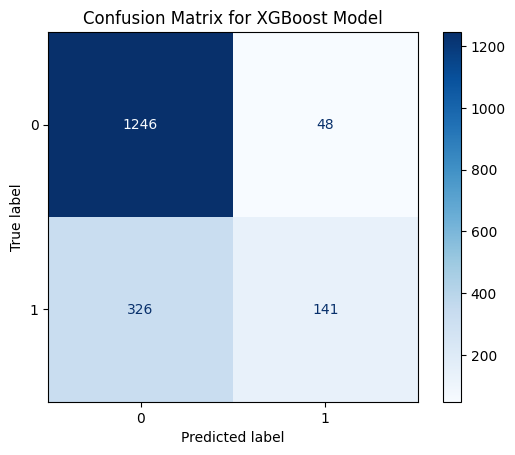

In [282]:
# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for XGBoost Model")
plt.show()

In [283]:
accuracy = accuracy_score(y_test, y_pred)
print (accuracy)

0.7876206700738216


[0]	validation_0-aucpr:0.58548
[1]	validation_0-aucpr:0.59809
[2]	validation_0-aucpr:0.60566
[3]	validation_0-aucpr:0.60774
[4]	validation_0-aucpr:0.61461
[5]	validation_0-aucpr:0.61575
[6]	validation_0-aucpr:0.62353
[7]	validation_0-aucpr:0.62361
[8]	validation_0-aucpr:0.64726
[9]	validation_0-aucpr:0.64788
[10]	validation_0-aucpr:0.64716
[11]	validation_0-aucpr:0.64360
[12]	validation_0-aucpr:0.64343
[13]	validation_0-aucpr:0.63917
[14]	validation_0-aucpr:0.63705
[15]	validation_0-aucpr:0.63616
[16]	validation_0-aucpr:0.64165
[17]	validation_0-aucpr:0.64140
[18]	validation_0-aucpr:0.64108


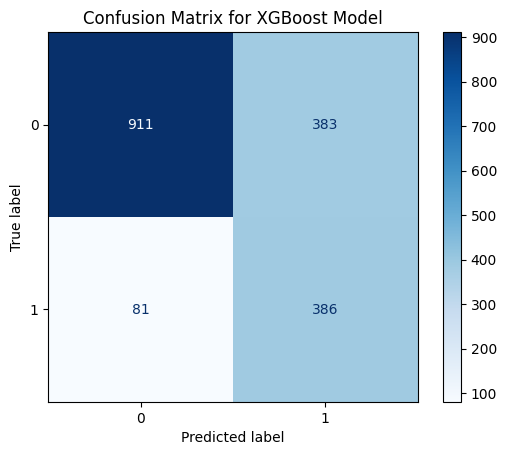

In [284]:
clf_xgb = xgb.XGBClassifier(
            objective='binary:logistic',  # For binary classification
            gamma=0.25,
            max_depth=4,
            reg_lambda=10,
            scale_pos_weight=3,
            subsample=0.9,
            colsample_bytree=0.5,
            n_estimators=100,              # Number of boosting rounds
            learning_rate=0.1,            # Step size shrinkage
            random_state=42,               # Random seed for reproducibility
            early_stopping_rounds=10,
            eval_metric='aucpr'
        )
clf_xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)
# Make predictions on the test set
y_pred = clf_xgb.predict(X_test)
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for XGBoost Model")
plt.show()

In [285]:
clf_xgb = xgb.XGBClassifier(
            objective='binary:logistic',  # For binary classification
            gamma=0.25,
            max_depth=4,
            reg_lambda=10,
            scale_pos_weight=3,
            subsample=0.9,
            colsample_bytree=0.5,
            n_estimators=1,              # Number of boosting rounds
            learning_rate=0.1,            # Step size shrinkage
            random_state=42,               # Random seed for reproducibility
        )
clf_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.25, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [288]:
import graphviz
bst = clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print ('%s: ' % importance_type, bst.get_score(importance_type=importance_type))

node_params = { 'shape':'box', 
                'style':'filled, rounded',
                'fillcolor':'#78cbe'}
leaf_params = { 'shape':'box', 
                'style':'filled',
                'fillcolor':'#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10", 
                condition_node_params=node_params,
                leaf_node_params=leaf_params)


weight:  {'MonthlyCharges': 3.0, 'TotalCharges': 6.0, 'Partner_Yes': 1.0, 'InternetService_DSL': 1.0, 'OnlineSecurity_No': 2.0, 'Contract_Month-to-month': 1.0}
gain:  {'MonthlyCharges': 58.66551208496094, 'TotalCharges': 43.05491256713867, 'Partner_Yes': 9.435646057128906, 'InternetService_DSL': 79.514404296875, 'OnlineSecurity_No': 132.28353881835938, 'Contract_Month-to-month': 1645.472412109375}
cover:  {'MonthlyCharges': 336.1199951171875, 'TotalCharges': 246.47413635253906, 'Partner_Yes': 81.36766815185547, 'InternetService_DSL': 891.3004150390625, 'OnlineSecurity_No': 818.0445556640625, 'Contract_Month-to-month': 1808.5587158203125}
total_gain:  {'MonthlyCharges': 175.9965362548828, 'TotalCharges': 258.3294677734375, 'Partner_Yes': 9.435646057128906, 'InternetService_DSL': 79.514404296875, 'OnlineSecurity_No': 264.56707763671875, 'Contract_Month-to-month': 1645.472412109375}
total_cover:  {'MonthlyCharges': 1008.3599853515625, 'TotalCharges': 1478.8448486328125, 'Partner_Yes': 81.

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH